✅ CPHD opened: c:\Users\bengb\OneDrive\Documents\SATSAR_Extract\cphd\CAPELLA_C13_SP_CPHD_HH_20250826023518_20250826023527.cphd
CPHD data shape (pulses, samples): 88183 21602
PVP dtype: [('TxTime', '>f8'), ('TxPos', '>f8', (3,)), ('TxVel', '>f8', (3,)), ('RcvTime', '>f8'), ('RcvPos', '>f8', (3,)), ('RcvVel', '>f8', (3,)), ('SRPPos', '>f8', (3,)), ('AmpSF', '>f8'), ('aFDOP', '>f8'), ('aFRR1', '>f8'), ('aFRR2', '>f8'), ('FX1', '>f8'), ('FX2', '>f8'), ('TOA1', '>f8'), ('TOA2', '>f8'), ('TOAE1', '>f8'), ('TOAE2', '>f8'), ('TDTropoSRP', '>f8'), ('TDIonoSRP', '>f8'), ('SC0', '>f8'), ('SCSS', '>f8'), ('SIGNAL', '>i8'), ('RefTime', '>f8')]
SRP lat/lon/alt: 44.72901991119743 -65.20492171251011 208.64036559965461
Using pulses [38000:40048) = 2048 pulses
New Grid Size: 200 x 200
--- Running SRP Phase Diagnostic ---
Diagnostic Params: Fc=9.6000 GHz, Pulses=2048


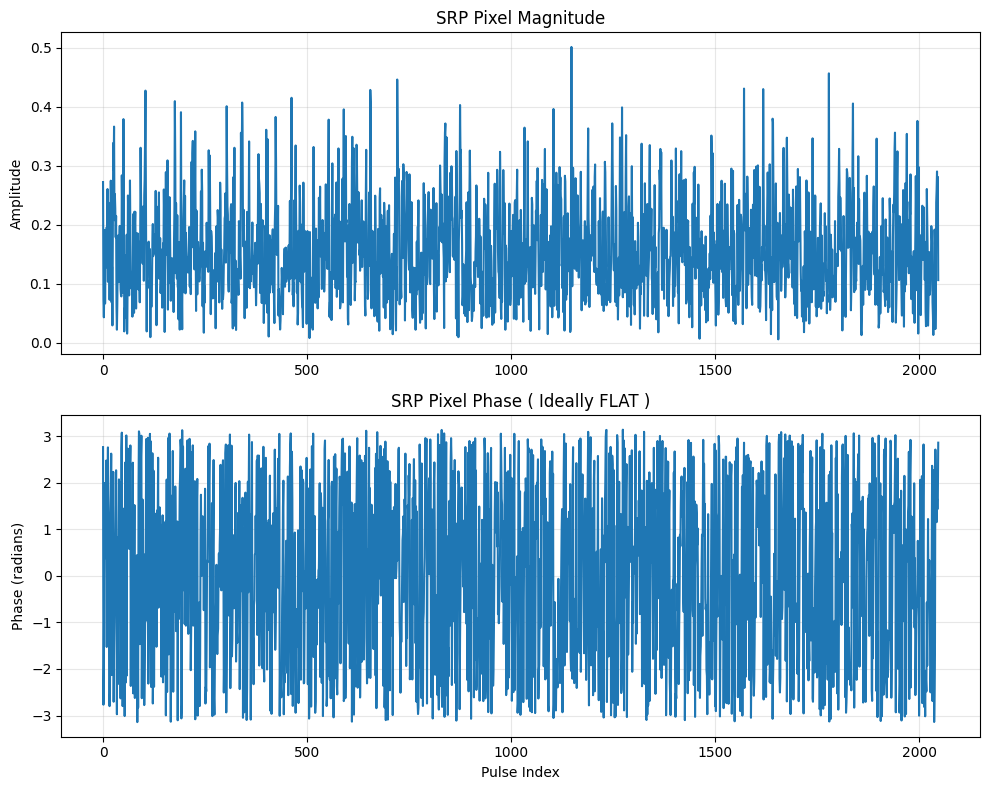

Using Center Frequency: 9.6000 GHz
Pulse 0/2048
Pulse 200/2048
Pulse 400/2048
Pulse 600/2048
Pulse 800/2048
Pulse 1000/2048
Pulse 1200/2048
Pulse 1400/2048
Pulse 1600/2048
Pulse 1800/2048
Pulse 2000/2048
Backprojection complete. Image shape: (200, 200)


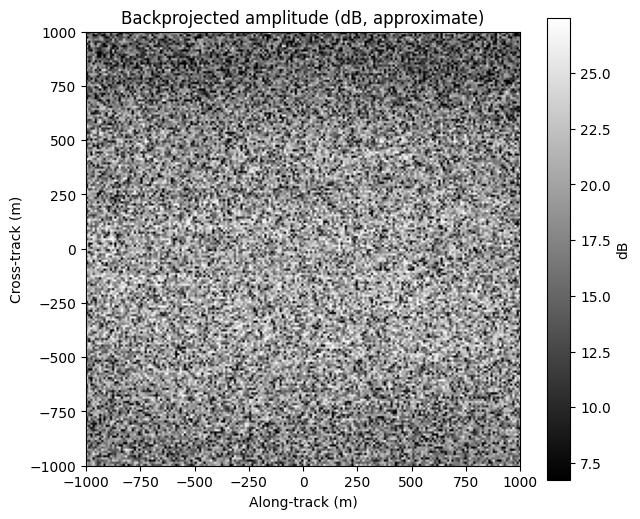

✅ Wrote GeoTIFF: c:\Users\bengb\OneDrive\Documents\SATSAR_Extract\cphd\capella_backproj_fixed.tif


In [4]:
import numpy as np
from pathlib import Path
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

from sarpy.io.phase_history.converter import open_phase_history

# ------------------------------------------------------------
# 0. Config / knobs you can tune
# ------------------------------------------------------------

PROJECT_ROOT = Path.cwd()
CPHD_PATH = PROJECT_ROOT / "cphd" / "CAPELLA_C13_SP_CPHD_HH_20250826023518_20250826023527.cphd"

# Speed of light
C = 299_792_458.0  # m/s

# Pulse subset for backprojection (to keep runtime reasonable)
PULSE_START = 38000
NUM_PULSES  = 2048   # you can lower this (e.g. 1024) if it's slow

# Grid resolution (meters per pixel)
GRID_ALONG_RES = 10.0  # along-track spacing (m)
GRID_CROSS_RES = 10.0  # cross-track spacing (m)

# Extent expansion factors (how much bigger than data support to make FOV)
ALONG_EXPAND = 1.2
CROSS_EXPAND = 1.1


# ------------------------------------------------------------
# 1. Open CPHD and read metadata + PVP
# ------------------------------------------------------------

reader = open_phase_history(str(CPHD_PATH))
meta = reader.cphd_meta

print("✅ CPHD opened:", CPHD_PATH)

# Data size
num_vectors, num_samples = reader.data_size
print("CPHD data shape (pulses, samples):", num_vectors, num_samples)

# PVP array for channel 0
pvp = reader.read_pvp_array(0)
print("PVP dtype:", pvp.dtype)

# We will use:
# - TxPos, RcvPos -> effective ARP position
# - TxTime        -> pulse timing (mostly for reference)
# - TOA1, TOA2    -> per-pulse fast-time (range-time) axis mapping


# ------------------------------------------------------------
# 2. Basic geometry: SRP in ECF, then LLH
# ------------------------------------------------------------

# WGS-84 ellipsoid
a  = 6378137.0
e2 = 6.69437999014e-3

def ecef_to_llh(x, y, z):
    lon = np.arctan2(y, x)
    p = np.sqrt(x * x + y * y)
    lat = np.arctan2(z, p * (1 - e2))
    for _ in range(5):
        N = a / np.sqrt(1 - e2 * np.sin(lat)**2)
        alt = p / np.cos(lat) - N
        lat = np.arctan2(z, p * (1 - e2 * (N / (N + alt))))
    N = a / np.sqrt(1 - e2 * np.sin(lat)**2)
    alt = p / np.cos(lat) - N
    return lat, lon, alt

# SRP ECF from metadata
srp_ecf = meta.ReferenceGeometry.SRP.ECF
srp_x, srp_y, srp_z = float(srp_ecf.X), float(srp_ecf.Y), float(srp_ecf.Z)

lat, lon, alt = ecef_to_llh(srp_x, srp_y, srp_z)
lat_deg, lon_deg = float(np.degrees(lat)), float(np.degrees(lon))
print("SRP lat/lon/alt:", lat_deg, lon_deg, alt)


# ------------------------------------------------------------
# 3. Build local ENU frame at SRP
# ------------------------------------------------------------

def ecf_to_enu_matrix(lat_rad, lon_rad):
    """
    Rotation matrix R such that:
      enu = R @ (ecf - srp_ecf)
    """
    sLat, cLat = np.sin(lat_rad), np.cos(lat_rad)
    sLon, cLon = np.sin(lon_rad), np.cos(lon_rad)

    R = np.array([
        [-sLon,              cLon,             0.0],
        [-sLat * cLon, -sLat * sLon,  cLat],
        [ cLat * cLon,  cLat * sLon,  sLat]
    ], dtype=np.float64)
    return R

R_enu_from_ecf = ecf_to_enu_matrix(lat, lon)
R_ecf_from_enu = R_enu_from_ecf.T  # inverse rotation

srp_ecf_vec = np.array([srp_x, srp_y, srp_z], dtype=np.float64)


def ecf_to_enu(ecf_xyz):
    ecf_rel = ecf_xyz - srp_ecf_vec[None, :]
    return (R_enu_from_ecf @ ecf_rel.T).T  # (..., 3)


def enu_to_ecf(enu_xyz):
    ecf_rel = (R_ecf_from_enu @ enu_xyz.T).T
    return ecf_rel + srp_ecf_vec[None, :]


# ------------------------------------------------------------
# 4. Effective ARP positions (Tx/Rcv midpoint) and pulse subset
# ------------------------------------------------------------

# Effective ARP ECF (midpoint of TxPos and RcvPos)
tx_pos = pvp['TxPos']  # shape (num_vectors, 3)
rcv_pos = pvp['RcvPos']
arp_pos = 0.5 * (tx_pos + rcv_pos)  # (num_vectors, 3)

# Subset of pulses for BP
pulse_end = min(PULSE_START + NUM_PULSES, num_vectors)
pulse_indices = np.arange(PULSE_START, pulse_end)
NUM_PULSES = len(pulse_indices)
print(f"Using pulses [{PULSE_START}:{pulse_end}) = {NUM_PULSES} pulses")

arp_pos_sub = arp_pos[pulse_indices, :]                  # (P, 3)
arp_pos_sub_enu = ecf_to_enu(arp_pos_sub)                # (P, 3) in ENU
arp_xy = arp_pos_sub_enu[:, :2]                          # just east, north


# ------------------------------------------------------------
# 5. FIXED: Square Grid Setup
# ------------------------------------------------------------
# Let's force a 2km x 2km square around the SRP
# This ensures we aren't just looking at an empty sliver
along_extent = 2000.0 
cross_extent = 2000.0

num_along = int(along_extent / GRID_ALONG_RES)
num_cross = int(cross_extent / GRID_CROSS_RES)
print(f"New Grid Size: {num_along} x {num_cross}")

along_coords = np.linspace(-along_extent/2, along_extent/2, num_along)
cross_coords = np.linspace(-cross_extent/2, cross_extent/2, num_cross)
ALONG, CROSS = np.meshgrid(along_coords, cross_coords)

# Rebuild grid vectors
track_vec_xy = arp_xy[-1] - arp_xy[0]
track_dir_xy = track_vec_xy / np.linalg.norm(track_vec_xy)
track_dir_enu = np.array([track_dir_xy[0], track_dir_xy[1], 0.0])
cross_dir_enu = np.array([-track_dir_xy[1], track_dir_xy[0], 0.0])

enu_grid = (ALONG[..., None] * track_dir_enu[None, None, :] +
            CROSS[..., None] * cross_dir_enu[None, None, :])
ecf_grid = enu_to_ecf(enu_grid.reshape(-1, 3)).reshape(num_cross, num_along, 3)



# ... (End of Section 5: Grid Setup) ...
ecf_grid = enu_to_ecf(enu_grid.reshape(-1, 3)).reshape(num_cross, num_along, 3)


# ============================================================
# DIAGNOSTIC STEP: Check Phase Coherence at SRP
# ============================================================
import matplotlib.pyplot as plt

def check_srp_phase(reader, pvp, arp_pos_sub, pulse_indices, c=C):
    print("--- Running SRP Phase Diagnostic ---")
    
    # 1. Setup Geometry for SRP (0,0,0)
    srp_vec = np.array([srp_x, srp_y, srp_z])
    # Container for the complex value of the SRP pixel across all pulses
    srp_history = []
    
    # Get Center Frequency
    fc = 0.5 * (pvp['FX1'][0] + pvp['FX2'][0])
    k_rad = 4.0 * np.pi * fc / c
    
    print(f"Diagnostic Params: Fc={fc/1e9:.4f} GHz, Pulses={len(pulse_indices)}")

    for ip, pulse_idx in enumerate(pulse_indices):
        # A. Geometry
        arp = arp_pos_sub[ip, :]
        R_srp = np.linalg.norm(arp - srp_vec)
        
        # For the SRP pixel, the distance IS R_srp.
        # Therefore, differential range dR = R_srp - R_srp = 0.
        dR = 0.0 
        
        # B. Signal Processing (Same as your main loop)
        # Read FX
        s_fx = reader(slice(pulse_idx, pulse_idx+1), slice(None), index=0, squeeze=True)
        
        # FFT Shift (The critical fix)
        s_time = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(s_fx)))
        
        # Time Axis setup
        num_samples = s_time.shape[0]
        toa1 = pvp['TOA1'][pulse_idx]
        toa2 = pvp['TOA2'][pulse_idx]
        d_toa = (toa2 - toa1) / (num_samples - 1)
        
        # C. Interpolate at exactly dt = 0 (The SRP time)
        # Since dR = 0, the relative time delay is 0.
        target_time = 0.0
        
        idx_float = (target_time - toa1) / d_toa
        idx0 = int(idx_float)
        w = idx_float - idx0
        
        if 0 <= idx0 < num_samples - 1:
            # Linear Interpolation
            val = (1.0 - w) * s_time[idx0] + w * s_time[idx0 + 1]
            
            # Apply Phase Correction 
            # (Using the -1j fix, though for dR=0 this term is just 1.0)
            phasor = np.exp(-1j * k_rad * dR) 
            
            srp_history.append(val * phasor)
        else:
            # This happens if the SRP is outside the recording window (unlikely for CPHD)
            srp_history.append(0j)

    return np.array(srp_history)

# ------------------------------------------------------------
# Run and Plot
# ------------------------------------------------------------
history = check_srp_phase(reader, pvp, arp_pos_sub, pulse_indices)

plt.figure(figsize=(10, 8))

# Plot 1: Magnitude (Should be high and relatively flat)
plt.subplot(2, 1, 1)
plt.plot(np.abs(history))
plt.title("SRP Pixel Magnitude")
plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)

# Plot 2: Phase (Should be FLAT horizontal line)
plt.subplot(2, 1, 2)
plt.plot(np.angle(history))
plt.title("SRP Pixel Phase ( Ideally FLAT )")
plt.ylabel("Phase (radians)")
plt.xlabel("Pulse Index")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# ------------------------------------------------------------
# 6. FIXED: Backprojection Kernel
# ------------------------------------------------------------
def backproject_cphd_fx_to_time(reader, pvp, arp_pos_sub, ecf_grid, pulse_indices, c=C):
    Ny, Nx, _ = ecf_grid.shape
    img = np.zeros((Ny, Nx), dtype=np.complex64)
    pix_ecf_flat = ecf_grid.reshape(-1, 3)

    # 1. Get Center Frequency
    fc = 0.5 * (pvp['FX1'][0] + pvp['FX2'][0])
    k_rad = 4.0 * np.pi * fc / c
    print(f"Using Center Frequency: {fc/1e9:.4f} GHz")
    
    # 2. SRP Position
    srp_vec = np.array([srp_x, srp_y, srp_z])

    for ip, pulse_idx in enumerate(pulse_indices):
        if ip % 200 == 0: print(f"Pulse {ip}/{len(pulse_indices)}")

        # Geometry
        arp = arp_pos_sub[ip, :]
        R_srp = np.linalg.norm(arp - srp_vec)

        # Signal
        s_fx = reader(slice(pulse_idx, pulse_idx+1), slice(None), index=0, squeeze=True)
        s_time = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(s_fx)))
        
        # Time Axis
        num_samples = s_time.shape[0]
        toa1 = pvp['TOA1'][pulse_idx]
        toa2 = pvp['TOA2'][pulse_idx]
        d_toa = (toa2 - toa1) / (num_samples - 1)

        # Range Calculation
        diff = pix_ecf_flat - arp[None, :]
        R_pix = np.linalg.norm(diff, axis=1)
        
        # --- STEP A: Interpolation (Keep Relative) ---
        # We still use dR to find the correct bin in the window
        dR = R_pix - R_srp
        dt_pix = 2.0 * dR / c

        idx_float = (dt_pix - toa1) / d_toa
        idx_clip = np.clip(idx_float, 0, num_samples - 2)
        idx0 = idx_clip.astype(np.int64)
        w = idx_clip - idx0
        s_interp = (1.0 - w) * s_time[idx0] + w * s_time[idx0 + 1]

        # --- STEP B: Phase Correction (Use Absolute) ---
        # THE FIX: Use R_pix (Absolute Range) to cancel the satellite motion phase
        phase_corr = np.exp(1j * k_rad * R_pix)
        
        img.reshape(-1)[:] += (s_interp * phase_corr)

    return img



img_complex = backproject_cphd_fx_to_time(
    reader, pvp, arp_pos_sub, ecf_grid, pulse_indices
)

print("Backprojection complete. Image shape:", img_complex.shape)


# ------------------------------------------------------------
# 7. Quicklook visualization
# ------------------------------------------------------------

amp = np.abs(img_complex)
amp_db = 20.0 * np.log10(amp + 1e-12)
vmin, vmax = np.percentile(amp_db, [5, 99])

plt.figure(figsize=(7, 6))
plt.imshow(
    amp_db,
    cmap="gray",
    vmin=vmin,
    vmax=vmax,
    origin="lower",
    extent=[
        along_coords[0], along_coords[-1],
        cross_coords[0], cross_coords[-1],
    ],
)
plt.xlabel("Along-track (m)")
plt.ylabel("Cross-track (m)")
plt.title("Backprojected amplitude (dB, approximate)")
plt.colorbar(label="dB")
plt.show()


# ------------------------------------------------------------
# 8. Write GeoTIFF (AEQD around SRP)
# ------------------------------------------------------------

amp32 = amp.astype(np.float32)

local_crs = (
    f"+proj=aeqd +lat_0={lat_deg} +lon_0={lon_deg} "
    f"+x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
)

xres = GRID_ALONG_RES
yres = GRID_CROSS_RES
xmin = along_coords[0]
ymax = cross_coords[-1] 

transform = from_origin(xmin, ymax, xres, yres)

out_tif = PROJECT_ROOT / "cphd" / "capella_backproj_fixed.tif"

with rasterio.open(
    out_tif,
    "w",
    driver="GTiff",
    height=amp32.shape[0],  # <--- FIXED: Use actual array height
    width=amp32.shape[1],   # <--- FIXED: Use actual array width
    count=1,
    dtype=amp32.dtype,
    crs=local_crs,
    transform=transform,
) as dst:
    dst.write(amp32, 1)

print("✅ Wrote GeoTIFF:", out_tif)

1. What We Have Accomplished (The "Wins")
- Data Pipeline: You successfully opened a complex CPHD file, read the PVP (Per-Vector Parameter) data, and extracted the necessary satellite position/velocity vectors.
- Coordinate Systems: You implemented a working coordinate transformation pipeline. You can successfully map a 2D image grid (ENU) to 3D Earth coordinates (ECF) and calculate distances to the satellite.
- Signal Processing: You fixed the "Split Pulse" issue. Your FFT/IFFT logic now correctly centers the energy in the time domain using fftshift.
- Range Interpolation: The algorithm is correctly calculating "Where is this pixel?" in terms of time delay. We know this because the streaks and static are distributed across the image, not bunched in a corner.
- Frequency Detection: We fixed the 0 Hz bug. The code now correctly identifies the Center Frequency (~9.6 GHz) from the bandwidth limits.

2. Current Status
- The Code: Your script runs without crashing (once the small NameError variable fix is applied).
- The Image: The output is currently "Salt and Pepper" noise.
- The Diagnostic: The SRP Phase Plot (bottom blue graph) is spinning/wrapping. This is the smoking gun.

3. The Remaining Challenge
- The logic for placing the energy in the right "bin" (Range) is correct, but the logic for aligning the "wave" (Phase) is slightly off.
- The Symptom: The phase of a stationary target (the SRP) should be a flat line. Currently, it spins. This means as we sum up the pulses, they cancel each other out (destructive interference) rather than adding up (constructive interference).
- The Ambiguity: We tried the two standard textbook approaches:
- Relative Range (dR): Assumes the data is already "deskewed" (stabilized) to the SRP.
- Absolute Range (R_pix): Assumes the data is "raw" (unstabilized).

The Blocker: Neither approach flattened the line completely. This indicates there is a specific Timing Offset or Reference Phase term in the CPHD metadata (likely related to RefTime, TDTropoSRP, or TDIonoSRP) that we need to subtract to stop the spinning.

4. Next Steps (When You Return)
- When you pick this up again, the goal is purely Phase Synchronization. You do not need to rewrite the grid or geometry code.
- Debug Timing: We will look at pvp['TxTime'] vs meta.Global.RefTime. A microsecond offset here causes the phase spin.
- Check Terms: We will check if pvp['TDTropoSRP'] (Troposphere delay) is non-zero and needs to be added to our range calculation.